# Import libraries

In [1]:
import json
import csv
import dill  # dill is a more powerful version of pickle
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('ggplot')
#plt.rcParams["figure.figsize"] = (20,3)
from tqdm import tqdm

from scipy.spatial.distance import cdist, euclidean
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric
import torch_geometric.utils
from torch_geometric.utils import from_networkx, negative_sampling, train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit



In [2]:
data_path = './scidocs/data/'
paper_cite_file = data_path + 'paper_metadata_view_cite_read.json'
paper_cls_file = data_path + 'paper_metadata_mag_mesh.json'
paper_rec_file = data_path + 'paper_metadata_recomm.json'
user_activity_and_citations_embeddings_path = data_path + 'specter-embeddings/user-citation.jsonl'

# Look at the data

In [3]:
papers_data = {}
with open(paper_cite_file, 'r') as f:
    papers_data = json.load(f)

In [4]:
list(list(papers_data.values())[0].keys())

['abstract', 'authors', 'cited_by', 'paper_id', 'references', 'title', 'year']

In [5]:
# papers_data = {}
# with open(paper_rec_file, 'r') as f:
#     papers_data = json.load(f)

In [6]:
list(list(papers_data.values())[0].keys())

['abstract', 'authors', 'cited_by', 'paper_id', 'references', 'title', 'year']

In [7]:
papers_df = pd.DataFrame(papers_data).T

In [8]:
#extra column
all(papers_df.index == papers_df.paper_id)

True

In [9]:
papers_df.head(5)

,abstract,authors,cited_by,paper_id,references,title,year
0003aa77bdefc1c75f9d2ba732635c132fc0c863,PROBLEM STATEMENT\nPelvic girdle pain (PGP) is...,"[40572137, 3675075, 48815127]","[e7e7a7fc07f516fd39b4b0cb7ff3a2acfe837c1a, e87...",0003aa77bdefc1c75f9d2ba732635c132fc0c863,"[420604a2d0161cd5b5d2df75dd6252f224c8b055, e78...",Pelvic Girdle Pain during or after Pregnancy: ...,2013
0007181efc556fd1fcda2642e9bd85dd0f0c32d6,Routers must perform packet classification at ...,"[23633340, 1688025, 1746289]","[76d64770fc8f032d047b034650c666e2c731c87e, bfb...",0007181efc556fd1fcda2642e9bd85dd0f0c32d6,"[0e541308cc7c5ce8574bab03c090b6a0c5c6355b, 1a1...",Packet Classification Using Tuple Space Search,1999
000c009765a276d166fc67595e107a9bc44f230d,The data of interest are assumed to be represe...,"[1869497, 3143096, 1746676]","[f354b0103c4bc8cb14bed77a27f5f4ffe580efdb, 7bf...",000c009765a276d166fc67595e107a9bc44f230d,"[d68725804eadecf83d707d89e12c5132bf376187, 57b...",Bayesian Compressive Sensing,2008
000f90380d768a85e2316225854fc377c079b5c4,Semantic image segmentation is an essential co...,"[3408089, 36665147, 11983029, 1789756]","[c2c0fda9b4e2a12fd4069ab545e90ec4a197e66d, 1fa...",000f90380d768a85e2316225854fc377c079b5c4,"[981fef7155742608b8b6673f4a9566158b76cd67, 942...",Full-Resolution Residual Networks for Semantic...,2017
00111610254bfb8ec16428501c2ca68dcf817474,We introduce the social study of bullying to t...,"[1729642, 2610963, 1832364, 3009549]","[6618b4dbea9cc0a229e603c0326eac957c420ac4, 49b...",00111610254bfb8ec16428501c2ca68dcf817474,"[639c1ec9edcbca7aa80ab56a52487def431aed5e, 899...",Learning from Bullying Traces in Social Media,2012


# Create graph

`get_graph` function

In [10]:
def get_graph(file_name):
    # Retreive the papers data
    papers_data = {}
    with open(file_name, 'r') as f:
        papers_data = json.loads(f.read())
    
    # Create a directed graph from the papers data
    G = nx.DiGraph()
    G.add_nodes_from(papers_data.keys())

    # Add edges to the graph based on the citations
    for paper_id, paper_attrs in papers_data.items():
        for citing_id in paper_attrs['cited_by']:
            if citing_id in G:
                G.add_edge(citing_id, paper_id)
        for cited_id in paper_attrs['references']:
            if cited_id in G:
                G.add_edge(paper_id, cited_id)

    return G

## Build graph from `paper_cite_file`

In [11]:
G = get_graph(paper_cite_file)

## Additional information about the graph

Number of nodes and edges

In [12]:
len(G), G.number_of_edges()

(142009, 834049)

Function for node info

In [13]:
def get_nodes_info(G):
    """
    Print the nodes info from the graph
    ## Parameters
    G : networkx.Graph
        The graph to get the nodes info from
    
    """
    # info about node degrees
    degrees = [d for n, d in G.degree()]
    print('\nNodes degrees info\nmean:', np.mean(degrees),
        '\nmedian:', np.median(degrees),
        '\nmax:', np.max(degrees),
        '\nmin:', np.min(degrees)
        )

    # info about nodes in-degrees
    degrees = [d for n, d in G.in_degree()]
    print('\nNodes in-degrees info\nmean:', np.mean(degrees),
        '\nmedian:', np.median(degrees),
        '\nmax:', np.max(degrees),
        '\nmin:', np.min(degrees)
        )

    # info about node in-degrees
    degrees = [d for n, d in G.out_degree()]
    print('\nNodes out-degrees info\nmean:', np.mean(degrees),
        '\nmedian:', np.median(degrees),
        '\nmax:', np.max(degrees),
        '\nmin:', np.min(degrees)
        )

In [14]:
get_nodes_info(G)


Nodes degrees info
mean: 11.746424522389425 
median: 5.0 
max: 4193 
min: 0

Nodes in-degrees info
mean: 5.873212261194713 
median: 1.0 
max: 4174 
min: 0

Nodes out-degrees info
mean: 5.873212261194713 
median: 3.0 
max: 484 
min: 0


In [15]:
# sorted list of nodes by in-degree
sorted_nodes = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)
sorted_nodes[:25]

[('2315fc6c2c0c4abd2443e26a26e7bb86df8e24cc', 4174),
 ('272216c1f097706721096669d85b2843c23fa77d', 2986),
 ('061356704ec86334dbbc073985375fe13cd39088', 2848),
 ('2c03df8b48bf3fa39054345bafabfeff15bfd11d', 2701),
 ('01fcae344d2edb715bcc63a40b6052c0331741bd', 2676),
 ('0b3cfbf79d50dae4a16584533227bb728e3522aa', 2500),
 ('1aec04aa64f165bb075cc4ce6ad79d36c89d62b6', 2487),
 ('c829b63a3ae72a47e1953e1295826c7b2f93bf50', 1778),
 ('cbcd9f32b526397f88d18163875d04255e72137f', 1568),
 ('14318685b5959b51d0f1e3db34643eb2855dc6d9', 1561),
 ('0b99d677883883584d9a328f6f2d54738363997a', 1557),
 ('722fcc35def20cfcca3ada76c8dd7a585d6de386', 1481),
 ('1827de6fa9c9c1b3d647a9d707042e89cf94abf0', 1399),
 ('54dd77bd7b904a6a69609c9f3af11b42f654ab5d', 1391),
 ('1e56ed3d2c855f848ffd91baa90f661772a279e1', 1371),
 ('6c8b30f63f265c32e26d999aa1fef5286b8308ad', 1349),
 ('0a10d64beb0931efdc24a28edaa91d539194b2e2', 1346),
 ('4afa6c2eb552ceef0e396fbfe449932492873034', 1341),
 ('0825788b9b5a18e3dfea5b0af123b5e939a4f564', 

### Connected components

Function to retreive connected components and their sizes

In [16]:
def get_conn_comp(G):
    """
    Get connected components of the graph and their sizes

    ## Parameters
    G : networkx.Graph
    
    ## Returns
    conn_comps : dictionary
        A dictionary where key is the size of the component and value is the nodes in component
    conn_comp_sizes : list
        A list of sizes of the connected components
    """
    # Create connected components dictionary where key is the size of the component and value is the nodes in component
    conn_comps = {len(c):c for c in nx.weakly_connected_components(G)}
    conn_comp_sizes = conn_comps.keys()
    
    return conn_comps, conn_comp_sizes

_, conn_comp_sizes = get_conn_comp(G)

In [17]:
sorted(conn_comp_sizes, reverse=True)[:20]

[120188, 34, 32, 23, 18, 15, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

## Find the suitable k-core decomposition subgraph 

### Decomposition function

In [18]:
def get_core_decomposition_subgraph(G, k):
    """
    Perform core decomposition to extract the k-core of the graph.
    
    ## Parameters:
        G : networkx.Graph
        k : int
            The minimum degree of the k-core
    
    ## Returns:
        k_core_subgraph : networkx.Graph
            The k-core of the graph as a NetworkX graph
    """
    # Extract the k-core of the graph
    k_core_subgraph = nx.k_core(G, k=k)
    
    return k_core_subgraph

### Look at the number of nodes for each decomposition

In [19]:
for k in range(3, 15+1, 3):
    print('k:', k)
    k_core_subgraph = get_core_decomposition_subgraph(G, k=k)
    print('nodes:', len(k_core_subgraph))

for k in range(16, 24+1, 1):
    print('k:', k)
    k_core_subgraph = get_core_decomposition_subgraph(G, k=k)
    print('nodes:', len(k_core_subgraph))

k: 3
nodes: 92784
k: 6
nodes: 59552
k: 9
nodes: 37005
k: 12
nodes: 22599
k: 15
nodes: 14974
k: 16
nodes: 13168
k: 17
nodes: 11495
k: 18
nodes: 10093
k: 19
nodes: 8734
k: 20
nodes: 7331
k: 21
nodes: 5936
k: 22
nodes: 4772
k: 23
nodes: 3875
k: 24
nodes: 3128


#### Based on the results k=20 is the optimal subgraph

In [20]:
G = get_core_decomposition_subgraph(G, k=20)
get_nodes_info(G)


Nodes degrees info
mean: 44.129859500750236 
median: 30.0 
max: 2182 
min: 20

Nodes in-degrees info
mean: 22.064929750375118 
median: 5.0 
max: 2164 
min: 0

Nodes out-degrees info
mean: 22.064929750375118 
median: 22.0 
max: 339 
min: 0


In [21]:
# sorted list of nodes by in-degree
sorted_nodes = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)
sorted_nodes[:25]

[('2315fc6c2c0c4abd2443e26a26e7bb86df8e24cc', 2164),
 ('061356704ec86334dbbc073985375fe13cd39088', 1737),
 ('01fcae344d2edb715bcc63a40b6052c0331741bd', 1681),
 ('2c03df8b48bf3fa39054345bafabfeff15bfd11d', 1681),
 ('272216c1f097706721096669d85b2843c23fa77d', 1392),
 ('0b3cfbf79d50dae4a16584533227bb728e3522aa', 1267),
 ('1aec04aa64f165bb075cc4ce6ad79d36c89d62b6', 1265),
 ('0b99d677883883584d9a328f6f2d54738363997a', 1011),
 ('14318685b5959b51d0f1e3db34643eb2855dc6d9', 1011),
 ('54dd77bd7b904a6a69609c9f3af11b42f654ab5d', 884),
 ('981fef7155742608b8b6673f4a9566158b76cd67', 826),
 ('1827de6fa9c9c1b3d647a9d707042e89cf94abf0', 813),
 ('009fba8df6bbca155d9e070a9bd8d0959bc693c2', 811),
 ('722fcc35def20cfcca3ada76c8dd7a585d6de386', 806),
 ('9201bf6f8222c2335913002e13fbac640fc0f4ec', 793),
 ('154728875d4668065ca6ba9fa2f5d2a1bcfc4a6e', 756),
 ('39dba6f22d72853561a4ed684be265e179a39e4f', 756),
 ('cbcd9f32b526397f88d18163875d04255e72137f', 748),
 ('6de2b1058c5b717878cce4e7e50d3a372cc4aaa6', 727),
 ('

#### Look at the connected components

In [22]:
_, conn_comp_sizes = get_conn_comp(G)
sorted(conn_comp_sizes, reverse=True)[:20]

[7331]

In [23]:
# G = get_graph(paper_cite_file)
# G = get_core_decomposition_subgraph(G, k=20)

In [24]:
len(G), len(G.edges)

(7331, 161758)

## Add embedding as a node attribute

### Download embeddings

In [25]:
def load_embeddings_from_jsonl(embeddings_path, G):
    embeddings = {}
    with open(embeddings_path, 'r') as f:
        for line in tqdm(f, desc='reading embeddings from file...'):
            line_json = json.loads(line)
            if line_json['paper_id'] in G:
                embeddings[line_json['paper_id']] = np.array(line_json['embedding'], dtype=np.float32)
    return embeddings

def load_embeddings_from_json(embeddings_path, G):
    embs = {}
    with open(embeddings_path, 'r') as f:
        all_embs = json.load(f)
        for id, emb in tqdm(all_embs.items(), desc='reading embeddings from file...'):
            if id in G.nodes:
                embs[id] = np.array(emb, dtype=np.float32)
    return embs

embeddings = load_embeddings_from_jsonl(user_activity_and_citations_embeddings_path, G)
#embeddings = load_embeddings_from_json('papers_embeddings_sp1.json', G)

reading embeddings from file...: 142009it [00:36, 3888.83it/s]


### Amount of resourses with embeddings

In [26]:
len(embeddings.keys())

7331

## Create a subgraph based on resourses with embs

In [27]:
G_cite = G.subgraph(embeddings.keys())
nx.set_node_attributes(G_cite, {node_id: {"x":embedding} for node_id, embedding in embeddings.items()})

### Information about the graph

In [28]:
len(G_cite), len(G_cite.edges), len(embeddings)

(7331, 161758, 7331)

In [29]:
get_nodes_info(G_cite)


Nodes degrees info
mean: 44.129859500750236 
median: 30.0 
max: 2182 
min: 20

Nodes in-degrees info
mean: 22.064929750375118 
median: 5.0 
max: 2164 
min: 0

Nodes out-degrees info
mean: 22.064929750375118 
median: 22.0 
max: 339 
min: 0


In [30]:
# sorted list of nodes by in-degree
sorted_nodes = sorted(G_cite.in_degree(), key=lambda x: x[1], reverse=True)
sorted_nodes[:25]


[('2315fc6c2c0c4abd2443e26a26e7bb86df8e24cc', 2164),
 ('061356704ec86334dbbc073985375fe13cd39088', 1737),
 ('01fcae344d2edb715bcc63a40b6052c0331741bd', 1681),
 ('2c03df8b48bf3fa39054345bafabfeff15bfd11d', 1681),
 ('272216c1f097706721096669d85b2843c23fa77d', 1392),
 ('0b3cfbf79d50dae4a16584533227bb728e3522aa', 1267),
 ('1aec04aa64f165bb075cc4ce6ad79d36c89d62b6', 1265),
 ('0b99d677883883584d9a328f6f2d54738363997a', 1011),
 ('14318685b5959b51d0f1e3db34643eb2855dc6d9', 1011),
 ('54dd77bd7b904a6a69609c9f3af11b42f654ab5d', 884),
 ('981fef7155742608b8b6673f4a9566158b76cd67', 826),
 ('1827de6fa9c9c1b3d647a9d707042e89cf94abf0', 813),
 ('009fba8df6bbca155d9e070a9bd8d0959bc693c2', 811),
 ('722fcc35def20cfcca3ada76c8dd7a585d6de386', 806),
 ('9201bf6f8222c2335913002e13fbac640fc0f4ec', 793),
 ('154728875d4668065ca6ba9fa2f5d2a1bcfc4a6e', 756),
 ('39dba6f22d72853561a4ed684be265e179a39e4f', 756),
 ('cbcd9f32b526397f88d18163875d04255e72137f', 748),
 ('6de2b1058c5b717878cce4e7e50d3a372cc4aaa6', 727),
 ('

## Upload the final graph

In [31]:
with open(data_path + 'cite_graph_k_20.pkl', 'wb') as f:
    dill.dump(G_cite, f)

# Link prediction

## Create LinkPredictionModel class

In [32]:
class LinkPredictionModel(torch.nn.Module):

    def __init__(self, layer_type, sz_in, num_layers=2, sz_hid=128, sz_out=64):
        super().__init__()

        # GNN layers with ReLU
        encoder = []
        encoder.append(layer_type(sz_in, sz_hid))
        encoder.append(nn.ReLU())
        for _ in range(num_layers-2):
            encoder.append(layer_type(sz_hid, sz_hid))
            encoder.append(nn.ReLU())
        encoder.append(layer_type(sz_hid, sz_out))
        self.encoder = nn.ModuleList(encoder)
        #self.H = None # torch.tensor(sz_in, sz_out)
    
    # Encoding: usual GNN propagation
    def encode(self, fts, adj):
        for l in self.encoder:
            if isinstance(l, nn.ReLU):
                fts = l(fts)
            else:
                fts = l(fts, adj)
            #self.H = fts
        return fts
    
    # Decoding: dot(H[i], H[j]) for each edge in edge_index
    # Larger dot => the model is more confident that this edge should exist
    def decode(self, H, edge_index):
        return (H[edge_index[0]] * H[edge_index[1]]).sum(dim=1)

## Train validation test split

In [33]:
def train_val_test_split(G: nx.Graph, val_ratio: float, test_ratio: float, neg_samp_ratio: float = 1.0) -> dict:
    """
    Split the graph into train, validation and test sets
    ## Parameters
    G : networkx.Graph
        The graph to split
    val_ratio : float
        The ratio of edges to use for the validation set
    test_ratio : float
        The ratio of edges to use for the test set
    neg_samp_ratio : float (default=1.0)
        The ratio of negative edges to sample for each positive edge
    ## Returns
    data : dict
        A dictionary containing the train, validation and test sets
    
    """

    data = from_networkx(G)
    # data.train_mask = data.val_mask = data.test_mask = data.y = None
    # data = train_test_split_edges(data, val_ratio, test_ratio)
    
    transform = RandomLinkSplit(
        num_val = val_ratio,
        num_test = test_ratio,
        is_undirected = False,
        add_negative_train_samples = True,
        neg_sampling_ratio = neg_samp_ratio
    )
    train_data, val_data, test_data = transform(data)
    
    # create positive and negative edge index for each set
    for d in [train_data, val_data, test_data]:
        d.pos_edge_index = d.edge_label_index[:, d.edge_label==1]
        d.neg_edge_index = d.edge_label_index[:, d.edge_label==0]
    
    data = {
        'train': train_data,
        'val': val_data,
        'test': test_data
    }
    return data


data = train_val_test_split(G_cite, 0.1, 0.1)
print(data['train'])
print(data['train'].x)
print()
print(f"Train set: {data['train'].pos_edge_index.shape[1]} positive edges, {data['train'].neg_edge_index.shape[1]} negative edges")
print(f"Val set: {data['val'].pos_edge_index.shape[1]} positive edges, {data['val'].neg_edge_index.shape[1]} negative edges")
print(f"Test set: {data['test'].pos_edge_index.shape[1]} positive edges, {data['test'].neg_edge_index.shape[1]} negative edges")

e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)


Data(x=[7331, 768], edge_index=[2, 129408], edge_label=[258816], edge_label_index=[2, 258816], pos_edge_index=[2, 129408], neg_edge_index=[2, 129408])
tensor([[-3.4043, -0.8110, -0.4617,  ..., -2.0357, -4.7027, -1.9705],
        [-0.0683, -2.2173,  2.7642,  ...,  1.7991, -1.7150, -1.3057],
        [-3.1576, -0.8872, -0.9146,  ..., -0.3438, -2.1279, -6.2688],
        ...,
        [-2.9965, -5.0376, -0.2961,  ..., -1.8625, -1.0913, -4.1346],
        [-8.9652, -2.3659, -1.8943,  ..., -1.9787, -2.0028, -1.0866],
        [-1.7753, -4.2636, -0.4025,  ...,  1.1788, -0.8236, -3.3802]])

Train set: 129408 positive edges, 129408 negative edges
Val set: 16175 positive edges, 16175 negative edges
Test set: 16175 positive edges, 16175 negative edges


In [34]:
def old_train_val_test_split(G, val_ratio, test_ratio):
    """
    Split the graph into train, validation and test sets
    ## Parameters
    G : networkx.Graph
        The graph to split
    val_ratio : float
        The ratio of edges to use for the validation set
    test_ratio : float
        The ratio of edges to use for the test set
    ## Returns
    data : torch_geometric.data.Data
        The data object containing the train, validation and test sets
    """

    data = from_networkx(G)
    data.train_mask = data.val_mask = data.test_mask = data.y = None
    data = train_test_split_edges(data, val_ratio, test_ratio)

    return data


old_data = old_train_val_test_split(G_cite, 0.1, 0.1)
print(old_data.x)
print(old_data)
print()
print(f'Train set: {old_data.train_pos_edge_index.shape[1]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {old_data.val_pos_edge_index.shape[1]} positive edges, {old_data.val_neg_edge_index.shape[1]} negative edges')
print(f'Test set: {old_data.test_pos_edge_index.shape[1]} positive edges, {old_data.test_neg_edge_index.shape[1]} negative edges')

e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


tensor([[-3.4043, -0.8110, -0.4617,  ..., -2.0357, -4.7027, -1.9705],
        [-0.0683, -2.2173,  2.7642,  ...,  1.7991, -1.7150, -1.3057],
        [-3.1576, -0.8872, -0.9146,  ..., -0.3438, -2.1279, -6.2688],
        ...,
        [-2.9965, -5.0376, -0.2961,  ..., -1.8625, -1.0913, -4.1346],
        [-8.9652, -2.3659, -1.8943,  ..., -1.9787, -2.0028, -1.0866],
        [-1.7753, -4.2636, -0.4025,  ...,  1.1788, -0.8236, -3.3802]])
Data(x=[7331, 768], val_pos_edge_index=[2, 8201], test_pos_edge_index=[2, 8201], train_pos_edge_index=[2, 131228], train_neg_adj_mask=[7331, 7331], val_neg_edge_index=[2, 8201], test_neg_edge_index=[2, 8201])

Train set: 131228 positive edges, we will sample the same number of negative edges at runtime
Val set: 8201 positive edges, 8201 negative edges
Test set: 8201 positive edges, 8201 negative edges


## Utility functions

In [35]:
# A utility function to compute the ROC-AUC score on given edges
def get_roc_auc(model, H, edge_index, labels):
    with torch.no_grad():
        #H = model.encode(data.x, data.train_pos_edge_index)
        z = model.decode(H, edge_index)
        s = z.sigmoid()
        return roc_auc_score(labels, s)
    
# A utility function to compute the F1-score on given edges
def get_f1_score(model, H, edge_index, labels):
    with torch.no_grad():
        z = model.decode(H, edge_index)
        s = z.sigmoid().numpy() >= 0.5
        return f1_score(labels, s)
    
# A utility function to compute the confusion matrix on given edges
def get_confusion_matrix(model, H, edge_index, labels):
    with torch.no_grad():
        z = model.decode(H, edge_index)
        s = z.sigmoid().numpy() >= 0.5
        return confusion_matrix(labels, s) 
    

# A utility function to plot all metrics
def plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all, auc_train_all, f1_train_all, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 2, figure=fig)
    loss_cut = 25

    # create sub plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    ax4 = fig.add_subplot(gs[2, :])
    
    # Plot loss for 10 epochs
    ax1.set_title(f'Loss {loss_cut} epoch')
    ax1.plot(np.arange(loss_cut)+1, loss_all[:loss_cut])
    ax1.set_xlabel('Epoch')
    
    # Plot loss for remaining epochs
    ax2.set_title(f'Loss after {loss_cut} epochs')
    ax2.plot(np.arange(loss_cut, num_epochs)+1, loss_all[loss_cut:])
    ax2.set_xlabel('Epoch')
    
    # Plot ROC AUC for remaining epochs
    ax3.set_title('ROC AUC Scores')
    ax3.plot(np.arange(num_epochs)+1, auc_train_all, label='ROC Train', alpha=0.8)
    ax3.plot(np.arange(num_epochs)+1, auc_val_all, label='ROC Validation', alpha=0.8)
    ax3.plot(np.arange(num_epochs)+1, auc_test_all, label='ROC Test', alpha=0.8)
    ax3.set_xlabel('Epoch')
    ax3.legend()

    # Plot F1-scores for remaining epochs
    ax4.set_title('F1-Scores')
    ax4.plot(np.arange(num_epochs)+1, f1_train_all, label='F1 Train', alpha=0.8)
    ax4.plot(np.arange(num_epochs)+1, f1_val_all, label='F1 Validation', alpha=0.8)
    ax4.plot(np.arange(num_epochs)+1, f1_test_all, label='F1 Test', alpha=0.8)
    ax4.set_xlabel('Epoch')
    ax4.legend()

    fig.tight_layout()

# Display confusion matrixes
def display_cms(cm_val, cm_test, title1, title2, figsize=(5,3)):
    f, axes = plt.subplots(1,2, figsize=figsize)

    axes[0].set_title(title1, fontsize=10)
    axes[0].grid(False)
    ConfusionMatrixDisplay(cm_val).plot(colorbar=False, ax=axes[0])

    axes[1].set_title(title2, fontsize=10)
    axes[1].grid(False)
    ConfusionMatrixDisplay(cm_test).plot(colorbar=False, ax=axes[1])

    f.tight_layout()
    plt.show()

# get binary metrics
def get_binary_metrics(model, H, edge_index, labels, auc_all: list, f1_all: list):
    auc = get_roc_auc(model, H, edge_index, labels)
    f1 = get_f1_score(model, H, edge_index, labels)
    cm = get_confusion_matrix(model, H, edge_index, labels)
    auc_all.append(auc)
    f1_all.append(f1)

    return auc, f1, cm

## Define training function

In [36]:
def train(model: LinkPredictionModel, data, num_epochs: int, test: bool=True, verbose: bool=True, plot: bool=True) -> torch.Tensor:
    """
    Trains a given model on a given dataset for a specified number of epochs, evaluating
    performance metrics on validation and test sets.

    ## Parameters:
      model : LinkPredictionModel
            The model to be trained.
      data : dict of torch_geometric.data.data.Data 
            The dataset containing training, validation, and test data.
      num_epochs : int
            The number of epochs to train the model.
      test : bool, default=True
            Whether to evaluate the model on the test dataset.
      verbose : bool, default=True
            Whether to print detailed progress messages.
      plot : bool, default=True
            Whether to plot performance metrics and confusion matrices.

    ## Returns:
      H : torch.Tensor 
            The final node representations learned by the model.
    """

    # Initialize containers for storing performance metrics over epochs
    loss_all = []
    auc_train_all = []
    auc_val_all = []
    auc_test_all = []
    f1_train_all = []
    f1_val_all = []
    f1_test_all = []
    
    # Set up the loss function and optimizer for binary classification
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare validation and test data: positive and negative edge indices and labels
    val_pos, val_neg = data['val'].pos_edge_index, data['val'].neg_edge_index
    val_edge_index = torch.cat([val_pos, val_neg], dim=1)
    val_labels = torch.cat([torch.ones(val_pos.shape[1]), torch.zeros(val_neg.shape[1])])
    
    test_pos, test_neg = data['test'].pos_edge_index, data['test'].neg_edge_index
    test_edge_index = torch.cat([test_pos, test_neg], dim=1)
    test_labels = torch.cat([torch.ones(test_pos.shape[1]), torch.zeros(test_neg.shape[1])])

    # Track the best F1 score on validation data
    f1_val_best = -1

    for epoch in range(num_epochs):
        # Sample negative edges for training
        train_pos = data['train'].pos_edge_index
        train_neg = data['train'].neg_edge_index #negative_sampling(
        #     edge_index=pos_edge_index,
        #     num_nodes=data.num_nodes,
        #     num_neg_samples=pos_edge_index.shape[1]
        # )
    
        # Zero gradients, encode graph data, and decode to get scores for edges
        optimizer.zero_grad()
        H = model.encode(data['train'].x, train_pos)
        train_edge_index = torch.cat([train_pos, train_neg], dim=1)
        z = model.decode(H, train_edge_index)

        # Compute loss and backpropagate
        train_labels = torch.cat([torch.ones(train_pos.shape[1]),
                                  torch.zeros(train_neg.shape[1])])
        loss = loss_fn(z, train_labels)
        loss.backward()
        optimizer.step()
        
        if test:
            # Evaluate model on validation and test sets, update metrics
            auc_train, f1_train, cm_train = get_binary_metrics(model, H, train_edge_index, train_labels, auc_train_all, f1_train_all)
            auc_val, f1_val, cm_val = get_binary_metrics(model, H, val_edge_index, val_labels, auc_val_all, f1_val_all)
            auc_test, f1_test, cm_test = get_binary_metrics(model, H, test_edge_index, test_labels, auc_test_all, f1_test_all)
            loss_all.append(loss.item())  # Convert loss to Python float and store
            
            if verbose and (epoch+1) % (50) == 0:
                # Print metrics every 50 epochs
                print(f'\n[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.4f} | AUC Train {auc_train:.3f} | AUC Val: {auc_val:.3f} | AUC Test: {auc_test:.3f}')
                print(f'                               | F1 Train: {f1_train:.3f} | F1 Val: {f1_val:.3f} | F1 Test: {f1_test:.3f}')
                if plot:
                    # Optionally plot confusion matrices
                    display_cms(cm_val, cm_test, title1=f'Epoch {epoch+1} Validation CM', title2=f'Epoch {epoch+1} Test CM')

            # Update best metrics if current F1 score on validation is the highest
            if f1_val > f1_val_best:
                f1_train_best, auc_train_best = f1_train, auc_train
                f1_val_best, auc_val_best, cm_val_best = f1_val, auc_val, cm_val
                f1_test_best, auc_test_best, cm_test_best, epoch_best, loss_best = f1_test, auc_test, cm_test, epoch+1, loss
                if verbose:
                    print(f'\n[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.4f} | AUC Train {auc_train:.3f} | AUC Val: {auc_val:.3f} | AUC Test: {auc_test:.3f}')
                    print(f'                            | F1 Train: {f1_train:.3f} | F1 Val: {f1_val:.3f} | F1 Test: {f1_test:.3f}')


    if test and verbose:
        # Print best overall metrics after training
        print(f'\nBest Epoch: {epoch_best} | Loss: {loss_best:.4f} | AUC Train {auc_train_best:.3f} | AUC Val: {auc_val_best:.3f} | AUC Test: {auc_test_best:.3f}')
        print(f'                         | F1 Train: {f1_train_best:.3f} | F1 Val: {f1_val_best:.3f} | F1 Test: {f1_test_best:.3f}')

    if test and plot:
        # Plot best confusion matrices and performance metrics over epochs
        display_cms(cm_val_best, cm_test_best, title1='Best Validation CM', title2='Best Test CM')
        plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all, auc_train_all, f1_train_all)
    
    return H


In [47]:
#old_data.test_neg_edge_index.shape[1]

train_pos = set(map(tuple, old_data.train_pos_edge_index.t().tolist()))
val_pos = set(map(tuple, old_data.val_pos_edge_index.t().tolist()))
test_pos = set(map(tuple, old_data.test_pos_edge_index.t().tolist()))

if len(train_pos.intersection(val_pos)) > 0:
    print("There is an overlap between train and validation edge indices.")
else:
    print("There is no overlap between train and validation edge indices.")

if len(train_pos.intersection(test_pos)) > 0:
    print("There is an overlap between train and test edge indices.")
else:
    print("There is no overlap between train and test edge indices.")

if len(val_pos.intersection(test_pos)) > 0:
    print("There is an overlap between validation and test edge indices.")
else:
    print("There is no overlap between validation and test edge indices.")


There is no overlap between train and validation edge indices.
There is no overlap between train and test edge indices.
There is no overlap between validation and test edge indices.


In [48]:
def generate_negative_samples(edge_index, num_nodes, num_neg_samples, forbidden_edge_sets):
    all_neg_edges = set()
    while len(all_neg_edges) < num_neg_samples:
        # Generate negative samples
        neg_edge_index = negative_sampling(
            edge_index=edge_index,
            num_nodes=num_nodes,
            num_neg_samples=num_neg_samples
            )
        
        # Convert to set of tuples for easy comparison
        neg_edge_set = set(map(tuple, neg_edge_index.t().tolist()))
        
        # Remove any negatives that appear in the forbidden sets
        for forbidden_edges in forbidden_edge_sets:
            forbidden_set = set(map(tuple, forbidden_edges.t().tolist()))
            neg_edge_set -= forbidden_set
        
        # Add unique negatives to the all_neg_edges set
        all_neg_edges.update(neg_edge_set)
    
    # Return the required number of negative samples
    return torch.tensor(list(all_neg_edges)[:num_neg_samples]).t()


In [51]:
def old_train(model, data, num_epochs, test=True, verbose=True, plot=True):
    """
    Trains a given model on a given dataset for a specified number of epochs, evaluating
    performance metrics on validation and test sets.

    ## Parameters:
      model : LinkPredictionModel
            The model to be trained.
      data : torch_geometric.data.data.Data 
            The dataset containing training, validation, and test data.
      num_epochs : int
            The number of epochs to train the model.
      test : bool, default=True
            Whether to evaluate the model on the test dataset.
      verbose : bool, default=True
            Whether to print detailed progress messages.
      plot : bool, default=True
            Whether to plot performance metrics and confusion matrices.

    ## Returns:
      H : tensor 
            The final node representations learned by the model.
    """

    # Initialize containers for storing performance metrics over epochs
    loss_all = []
    auc_train_all = []
    auc_val_all = []
    auc_test_all = []
    f1_train_all = []
    f1_val_all = []
    f1_test_all = []
    
    # Set up the loss function and optimizer for binary classification
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare validation and test data: positive and negative edge indices and labels
    val_pos, val_neg = data.val_pos_edge_index, data.val_neg_edge_index
    val_edge_index = torch.cat([val_pos, val_neg], dim=1)
    val_labels = torch.cat([torch.ones(val_pos.shape[1]), torch.zeros(val_neg.shape[1])])
    
    test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
    test_edge_index = torch.cat([test_pos, test_neg], dim=1)
    test_labels = torch.cat([torch.ones(test_pos.shape[1]), torch.zeros(test_neg.shape[1])])

    # Track the best F1 score on validation data
    f1_val_best = -1

    for epoch in range(num_epochs):
        # Sample negative edges for training
        train_pos = data.train_pos_edge_index
        # Generate negative samples for training, ensuring no overlap with val or test positive edges
        train_neg = generate_negative_samples(
            edge_index=train_pos, 
            num_nodes=data.num_nodes,
            num_neg_samples=train_pos.shape[1], 
            forbidden_edge_sets=[val_pos, test_pos, val_neg, test_neg]
        )
    
        # Zero gradients, encode graph data, and decode to get scores for edges
        optimizer.zero_grad()
        H = model.encode(data.x, train_pos)
        train_edge_index = torch.cat([train_pos, train_neg], dim=1)
        z = model.decode(H, train_edge_index)

        # Compute loss and backpropagate
        train_labels = torch.cat([torch.ones(train_pos.shape[1]),
                            torch.zeros(train_neg.shape[1])])
        loss = loss_fn(z, train_labels)
        loss.backward()
        optimizer.step()
        
        if test:
            # Evaluate model on validation and test sets, update metrics
            auc_train, f1_train, cm_train = get_binary_metrics(model, H, train_edge_index, train_labels, auc_train_all, f1_train_all)
            auc_val, f1_val, cm_val = get_binary_metrics(model, H, val_edge_index, val_labels, auc_val_all, f1_val_all)
            auc_test, f1_test, cm_test = get_binary_metrics(model, H, test_edge_index, test_labels, auc_test_all, f1_test_all)
            loss_all.append(loss.item())  # Convert loss to Python float and store
            
            if verbose and (epoch) % (50-1) == 0:
                # Print metrics every 50 epochs
                print(f'\n[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.4f} | AUC Train {auc_train:.3f} | AUC Val: {auc_val:.3f} | AUC Test: {auc_test:.3f}')
                print(f'                            | F1 Train: {f1_train:.3f} | F1 Val: {f1_val:.3f} | F1 Test: {f1_test:.3f}')
                if plot:
                    # Optionally plot confusion matrices
                    display_cms(cm_val, cm_test, title1=f'Epoch {epoch+1} Validation CM', title2=f'Epoch {epoch+1} Test CM')

            # Update best metrics if current F1 score on validation is the highest
            if f1_val > f1_val_best:
                f1_val_best, auc_val_best, cm_val_best = f1_val, auc_val, cm_val
                f1_test_best, auc_test_best, cm_test_best, epoch_best, loss_best = f1_test, auc_test, cm_test, epoch+1, loss
                if verbose:
                    print(f'\n[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.4f} | AUC Train {auc_train:.3f} | AUC Val: {auc_val:.3f} | AUC Test: {auc_test:.3f}')
                    print(f'                            | F1 Train: {f1_train:.3f} | F1 Val: {f1_val:.3f} | F1 Test: {f1_test:.3f}')


    if test and verbose:
        # Print best overall metrics after training
        print(f'\nBest Epoch: {epoch_best} | Loss: {loss_best:.4f} | AUC Train {auc_train:.3f} | AUC Val: {auc_val_best:.3f} | AUC Test: {auc_test_best:.3f}')
        print(f'                         | F1 Train: {f1_train:.3f} | F1 Val: {f1_val_best:.3f} | F1 Test: {f1_test_best:.3f}')

    if test and plot:
        # Plot best confusion matrices and performance metrics over epochs
        display_cms(cm_val_best, cm_test_best, title1='Best Validation CM', title2='Best Test CM')
        plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all, auc_train_all, f1_train_all)
    
    return H


## Model training

### 2-layer GCN, hidden=128, output=64

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 128)
    (1): ReLU()
    (2): GCNConv(128, 64)
  )
)

[Epoch 1/100] Loss: 87.0604 | AUC Train 0.500 | AUC Val: 0.500 | AUC Test: 0.500
                            | F1 Train: 0.667 | F1 Val: 0.667 | F1 Test: 0.667


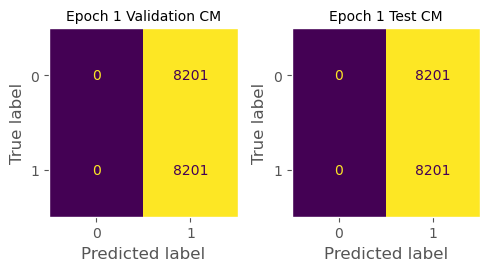


[Epoch 1/100] Loss: 87.0604 | AUC Train 0.500 | AUC Val: 0.500 | AUC Test: 0.500
                            | F1 Train: 0.667 | F1 Val: 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 25.8450 | AUC Train 0.513 | AUC Val: 0.513 | AUC Test: 0.513
                            | F1 Train: 0.667 | F1 Val: 0.667 | F1 Test: 0.667

[Epoch 3/100] Loss: 12.9480 | AUC Train 0.659 | AUC Val: 0.656 | AUC Test: 0.658
                            | F1 Train: 0.672 | F1 Val: 0.671 | F1 Test: 0.671

[Epoch 4/100] Loss: 13.8652 | AUC Train 0.664 | AUC Val: 0.661 | AUC Test: 0.668
                            | F1 Train: 0.672 | F1 Val: 0.672 | F1 Test: 0.671

[Epoch 6/100] Loss: 9.4112 | AUC Train 0.755 | AUC Val: 0.747 | AUC Test: 0.752
                            | F1 Train: 0.681 | F1 Val: 0.681 | F1 Test: 0.680

[Epoch 7/100] Loss: 6.0039 | AUC Train 0.840 | AUC Val: 0.830 | AUC Test: 0.829
                            | F1 Train: 0.701 | F1 Val: 0.700 | F1 Test: 0.699

[Epoch 8/100] Loss: 3.7095 | AUC Tr

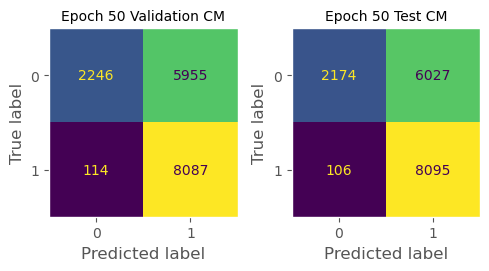


[Epoch 51/100] Loss: 0.5850 | AUC Train 0.865 | AUC Val: 0.851 | AUC Test: 0.838
                            | F1 Train: 0.735 | F1 Val: 0.729 | F1 Test: 0.727

[Epoch 52/100] Loss: 0.5849 | AUC Train 0.865 | AUC Val: 0.852 | AUC Test: 0.839
                            | F1 Train: 0.737 | F1 Val: 0.731 | F1 Test: 0.729

[Epoch 53/100] Loss: 0.5831 | AUC Train 0.867 | AUC Val: 0.853 | AUC Test: 0.840
                            | F1 Train: 0.738 | F1 Val: 0.732 | F1 Test: 0.730

[Epoch 54/100] Loss: 0.5826 | AUC Train 0.868 | AUC Val: 0.854 | AUC Test: 0.842
                            | F1 Train: 0.739 | F1 Val: 0.734 | F1 Test: 0.732

[Epoch 55/100] Loss: 0.5799 | AUC Train 0.870 | AUC Val: 0.855 | AUC Test: 0.843
                            | F1 Train: 0.741 | F1 Val: 0.735 | F1 Test: 0.734

[Epoch 56/100] Loss: 0.5787 | AUC Train 0.871 | AUC Val: 0.856 | AUC Test: 0.844
                            | F1 Train: 0.742 | F1 Val: 0.736 | F1 Test: 0.735

[Epoch 57/100] Loss: 0.5769 | AUC

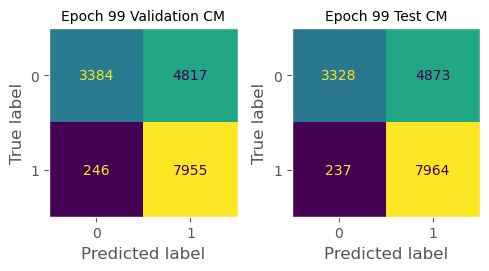


[Epoch 99/100] Loss: 0.5526 | AUC Train 0.885 | AUC Val: 0.867 | AUC Test: 0.860
                            | F1 Train: 0.766 | F1 Val: 0.759 | F1 Test: 0.757

[Epoch 100/100] Loss: 0.5540 | AUC Train 0.884 | AUC Val: 0.868 | AUC Test: 0.860
                            | F1 Train: 0.766 | F1 Val: 0.759 | F1 Test: 0.757

Best Epoch: 100 | Loss: 0.5540 | AUC Train 0.884 | AUC Val: 0.868 | AUC Test: 0.860
                         | F1 Train: 0.766 | F1 Val: 0.759 | F1 Test: 0.757


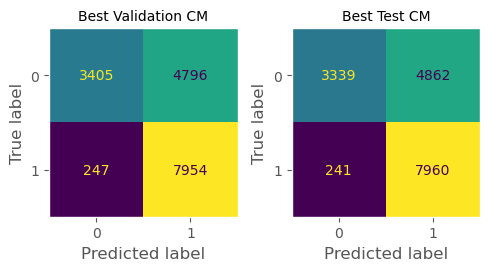

tensor([[-0.0263,  0.1188,  0.1002,  ...,  0.0938, -0.1954,  0.3052],
        [-0.1095,  0.1947,  0.1331,  ..., -0.0125, -0.1705, -0.1653],
        [-0.3662, -0.0299, -0.3454,  ...,  0.1714,  0.0245,  0.0810],
        ...,
        [-0.0812,  0.0020, -0.2802,  ..., -0.1973,  0.6013, -0.4803],
        [-0.3933, -0.8191, -0.0635,  ...,  0.1495,  0.0321, -0.0143],
        [-0.0746,  0.1056,  0.0129,  ..., -0.0557, -0.1988, -0.1828]],
       grad_fn=<AddBackward0>)

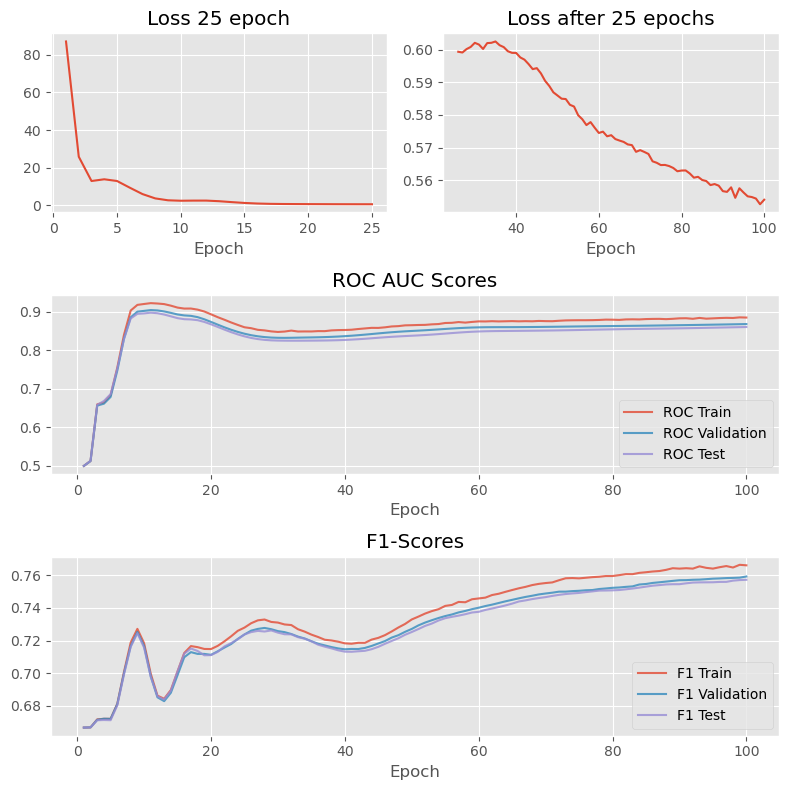

In [52]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv, old_data.x.shape[1])
print(model)
old_train(model, old_data, num_epochs=100)  #AUC Val: 0.869 | AUC Test: 0.877
                                    #F1 Val: 0.730  | F1 Test: 0.731

### 2-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 128)
  )
)

[Epoch 1/100] Loss: 242.5498 | AUC Train 0.500 | AUC Val: 0.500 | AUC Test: 0.500
                            | F1 Train: 0.667 | F1 Val: 0.667 | F1 Test: 0.667


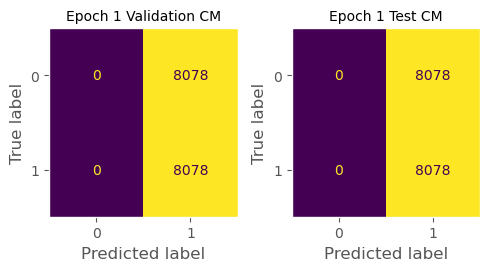


[Epoch 1/100] Loss: 242.5498 | AUC Train 0.500 | AUC Val: 0.500 | AUC Test: 0.500
                            | F1 Train: 0.667 | F1 Val: 0.667 | F1 Test: 0.667

[Epoch 3/100] Loss: 28.7257 | AUC Train 0.524 | AUC Val: 0.523 | AUC Test: 0.523
                            | F1 Train: 0.667 | F1 Val: 0.667 | F1 Test: 0.667

[Epoch 6/100] Loss: 19.0721 | AUC Train 0.579 | AUC Val: 0.577 | AUC Test: 0.577
                            | F1 Train: 0.669 | F1 Val: 0.669 | F1 Test: 0.668

[Epoch 7/100] Loss: 10.7922 | AUC Train 0.727 | AUC Val: 0.724 | AUC Test: 0.721
                            | F1 Train: 0.682 | F1 Val: 0.683 | F1 Test: 0.681

[Epoch 8/100] Loss: 6.7731 | AUC Train 0.835 | AUC Val: 0.822 | AUC Test: 0.823
                            | F1 Train: 0.703 | F1 Val: 0.702 | F1 Test: 0.703

[Epoch 9/100] Loss: 5.4846 | AUC Train 0.866 | AUC Val: 0.852 | AUC Test: 0.852
                            | F1 Train: 0.711 | F1 Val: 0.710 | F1 Test: 0.709

[Epoch 18/100] Loss: 1.1294 | AUC 

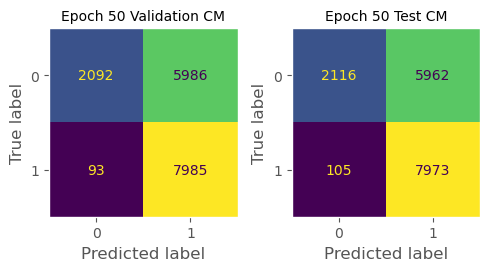


[Epoch 68/100] Loss: 0.5754 | AUC Train 0.890 | AUC Val: 0.869 | AUC Test: 0.872
                            | F1 Train: 0.729 | F1 Val: 0.726 | F1 Test: 0.726

[Epoch 69/100] Loss: 0.5735 | AUC Train 0.892 | AUC Val: 0.871 | AUC Test: 0.873
                            | F1 Train: 0.732 | F1 Val: 0.729 | F1 Test: 0.728

[Epoch 70/100] Loss: 0.5729 | AUC Train 0.893 | AUC Val: 0.872 | AUC Test: 0.874
                            | F1 Train: 0.734 | F1 Val: 0.731 | F1 Test: 0.730

[Epoch 71/100] Loss: 0.5728 | AUC Train 0.892 | AUC Val: 0.873 | AUC Test: 0.875
                            | F1 Train: 0.736 | F1 Val: 0.734 | F1 Test: 0.732

[Epoch 72/100] Loss: 0.5706 | AUC Train 0.894 | AUC Val: 0.874 | AUC Test: 0.876
                            | F1 Train: 0.738 | F1 Val: 0.735 | F1 Test: 0.734

[Epoch 73/100] Loss: 0.5705 | AUC Train 0.894 | AUC Val: 0.875 | AUC Test: 0.876
                            | F1 Train: 0.740 | F1 Val: 0.737 | F1 Test: 0.737

[Epoch 74/100] Loss: 0.5704 | AUC

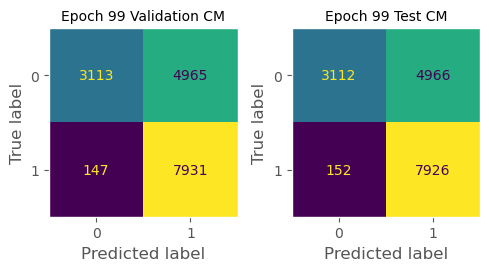


[Epoch 99/100] Loss: 0.5524 | AUC Train 0.902 | AUC Val: 0.883 | AUC Test: 0.884
                            | F1 Train: 0.761 | F1 Val: 0.756 | F1 Test: 0.756

[Epoch 100/100] Loss: 0.5516 | AUC Train 0.903 | AUC Val: 0.884 | AUC Test: 0.884
                            | F1 Train: 0.761 | F1 Val: 0.756 | F1 Test: 0.756

Best Epoch: 100 | Loss: 0.5516 | AUC Train 0.903 | AUC Val: 0.884 | AUC Test: 0.884
                         | F1 Train: 0.761 | F1 Val: 0.756 | F1 Test: 0.756


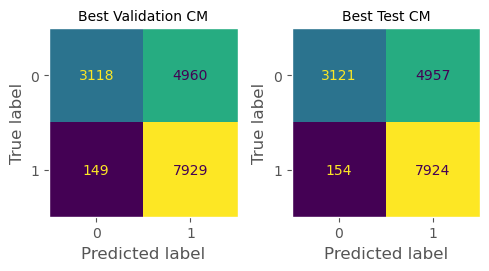

tensor([[-3.3200e-03,  3.0108e-01,  1.2580e+00,  ...,  5.7139e-01,
          2.3831e-01, -5.7229e-01],
        [ 6.7108e-02,  9.2578e-02, -1.4865e-01,  ...,  7.3520e-02,
         -9.2526e-04,  2.3946e-02],
        [ 5.5514e-03,  5.3560e-02, -7.1970e-02,  ...,  3.8054e-02,
         -4.2608e-02,  2.6798e-02],
        ...,
        [ 1.2079e-01,  8.8698e-02, -2.5437e-01,  ..., -1.7090e-02,
          8.0090e-02,  1.7983e-02],
        [ 3.8146e-02, -6.9292e-02, -5.5853e-02,  ...,  3.0126e-02,
         -6.3473e-03,  9.8520e-02],
        [-4.3569e-01, -2.8267e-01,  3.2047e-03,  ...,  7.7989e-02,
          5.8355e-01,  1.9683e-01]], grad_fn=<AddBackward0>)

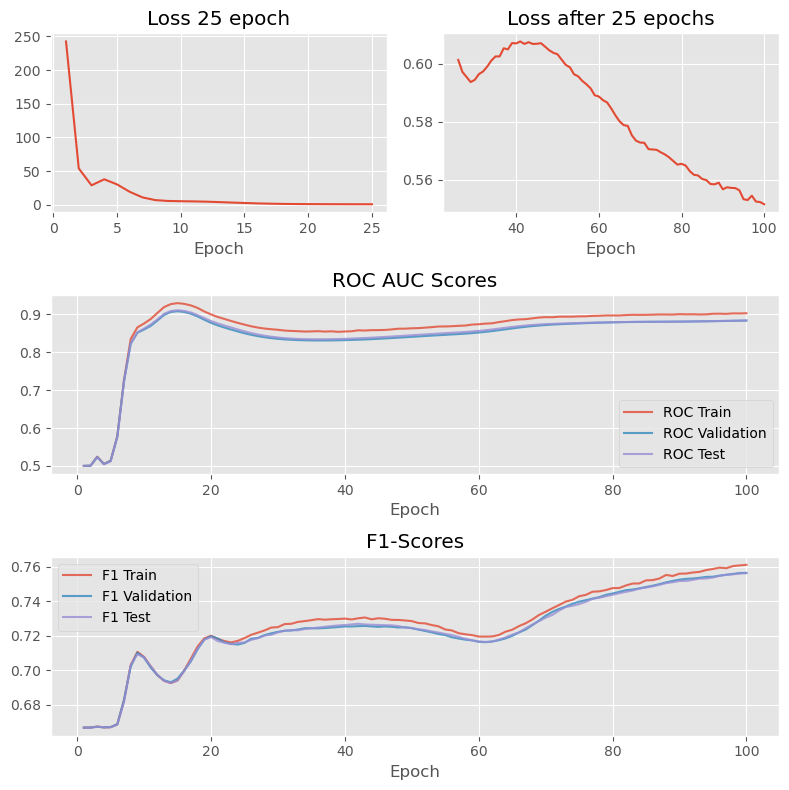

In [43]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            old_data.x.shape[1],
                            sz_hid=256,
                            sz_out=128)
print(model)
old_train(model, old_data, num_epochs=100)   # AUC Val: 0.875 | AUC Test: 0.879
                                     # F1 Val: 0.764  | F1 Test: 0.768

### 3-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 122.2062 | AUC Val: 0.500 | AUC Test: 0.500
                                | F1 Val: 0.667 | F1 Test: 0.667


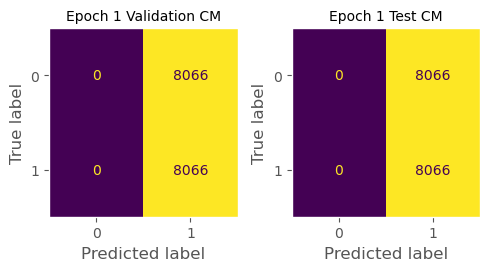

[Epoch 1/100] Loss: 122.2062 | AUC Val: 0.500 | AUC Test: 0.500
                             | F1 Val: 0.667 | F1 Test: 0.667
[Epoch 4/100] Loss: 8.4495 | AUC Val: 0.790 | AUC Test: 0.794
                             | F1 Val: 0.667 | F1 Test: 0.667
[Epoch 5/100] Loss: 5.2952 | AUC Val: 0.871 | AUC Test: 0.875
                             | F1 Val: 0.667 | F1 Test: 0.667
[Epoch 6/100] Loss: 3.3788 | AUC Val: 0.897 | AUC Test: 0.900
                             | F1 Val: 0.671 | F1 Test: 0.672
[Epoch 7/100] Loss: 2.3327 | AUC Val: 0.901 | AUC Test: 0.902
                             | F1 Val: 0.683 | F1 Test: 0.684
[Epoch 8/100] Loss: 1.9001 | AUC Val: 0.901 | AUC Test: 0.902
                             | F1 Val: 0.689 | F1 Test: 0.689
[Epoch 9/100] Loss: 1.5518 | AUC Val: 0.903 | AUC Test: 0.904
                             | F1 Val: 0.693 | F1 Test: 0.693
[Epoch 10/100] Loss: 1.1965 | AUC Val: 0.903 | AUC Test: 0.904
                             | F1 Val: 0.705 | F1 Test: 0.705
[Epoc

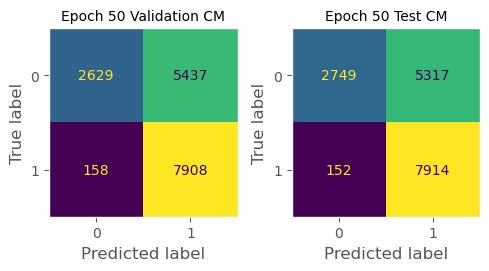

[Epoch 50/100] Loss: 0.5365 | AUC Val: 0.899 | AUC Test: 0.902
                             | F1 Val: 0.739 | F1 Test: 0.743
[Epoch 51/100] Loss: 0.5356 | AUC Val: 0.898 | AUC Test: 0.901
                             | F1 Val: 0.741 | F1 Test: 0.746
[Epoch 52/100] Loss: 0.5342 | AUC Val: 0.898 | AUC Test: 0.901
                             | F1 Val: 0.742 | F1 Test: 0.748
[Epoch 53/100] Loss: 0.5328 | AUC Val: 0.898 | AUC Test: 0.901
                             | F1 Val: 0.744 | F1 Test: 0.749
[Epoch 54/100] Loss: 0.5307 | AUC Val: 0.899 | AUC Test: 0.902
                             | F1 Val: 0.744 | F1 Test: 0.750
[Epoch 55/100] Loss: 0.5295 | AUC Val: 0.901 | AUC Test: 0.904
                             | F1 Val: 0.744 | F1 Test: 0.749
[Epoch 57/100] Loss: 0.5282 | AUC Val: 0.904 | AUC Test: 0.906
                             | F1 Val: 0.745 | F1 Test: 0.750
[Epoch 58/100] Loss: 0.5260 | AUC Val: 0.904 | AUC Test: 0.906
                             | F1 Val: 0.747 | F1 Test: 0.751


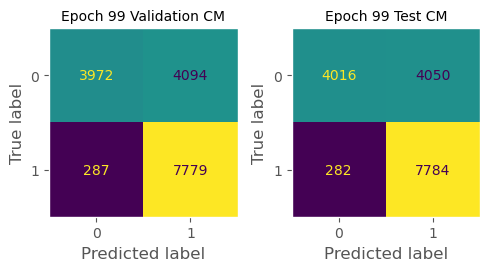

[Epoch 99/100] Loss: 0.4855 | AUC Val: 0.914 | AUC Test: 0.916
                             | F1 Val: 0.780 | F1 Test: 0.782
[Epoch 100/100] Loss: 0.4844 | AUC Val: 0.914 | AUC Test: 0.916
                             | F1 Val: 0.780 | F1 Test: 0.783

Best Epoch: 100 | Loss: 0.4844 | AUC Val: 0.914 | AUC Test: 0.916
                          | F1 Val: 0.780 | F1 Test: 0.783


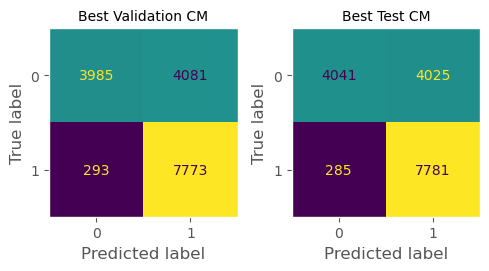

tensor([[-0.1285, -0.0268,  0.0036,  ...,  0.1564,  0.1560,  0.0947],
        [ 0.2184, -0.0192,  0.2247,  ..., -0.2015, -0.0713, -0.0999],
        [-0.0047, -0.0154, -0.1481,  ..., -0.0390, -0.1230,  0.1188],
        ...,
        [ 0.2457, -0.0358, -0.2312,  ...,  0.1186,  0.3688,  0.0356],
        [ 0.1251,  0.1499, -0.3413,  ..., -0.0912,  0.3109, -0.3796],
        [-0.1016,  0.0395, -0.0718,  ..., -0.0550,  0.0326,  0.0123]],
       grad_fn=<AddBackward0>)

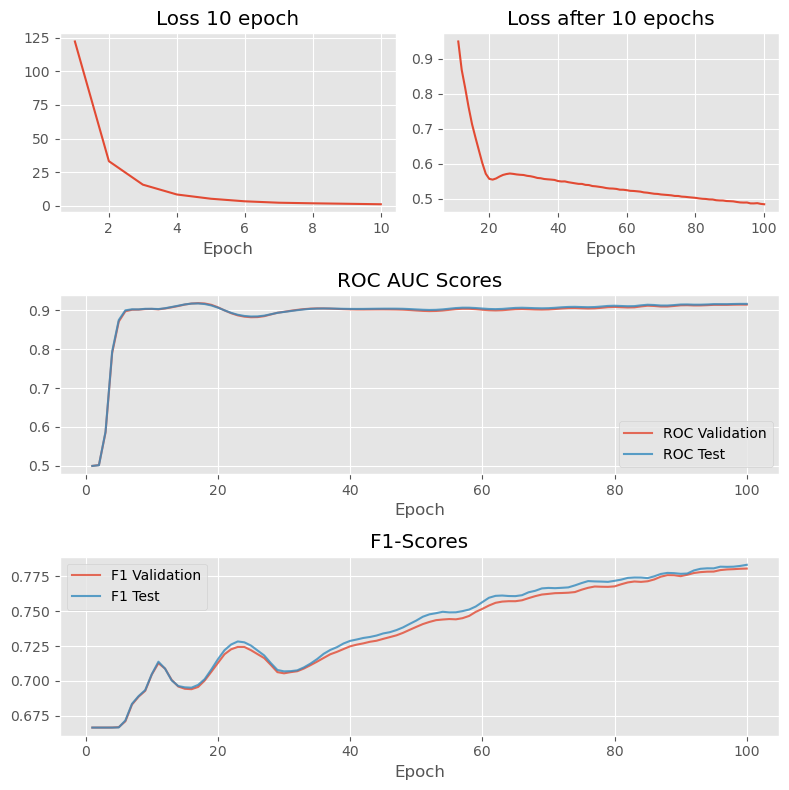

In [57]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            old_data.x.shape[1],
                            num_layers=3,
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, old_data, num_epochs=100)  # AUC Val: 0.914 | AUC Test: 0.916
                                    # F1 Val: 0.780 | F1 Test: 0.783

### 4-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 256)
    (5): ReLU()
    (6): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 42.9818 | AUC Val: 0.500 | AUC Test: 0.500
                                | F1 Val: 0.667 | F1 Test: 0.667


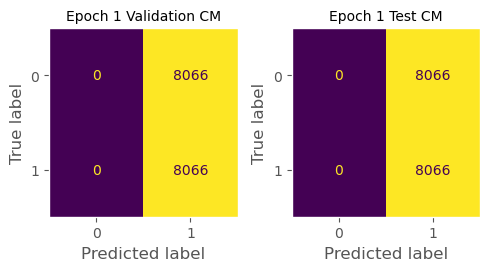

[Epoch 1/100] Loss: 42.9818 | AUC Val: 0.500 | AUC Test: 0.500
                             | F1 Val: 0.667 | F1 Test: 0.667
[Epoch 6/100] Loss: 1.2467 | AUC Val: 0.890 | AUC Test: 0.889
                             | F1 Val: 0.667 | F1 Test: 0.667
[Epoch 7/100] Loss: 0.9834 | AUC Val: 0.898 | AUC Test: 0.898
                             | F1 Val: 0.668 | F1 Test: 0.668
[Epoch 8/100] Loss: 0.8118 | AUC Val: 0.904 | AUC Test: 0.904
                             | F1 Val: 0.670 | F1 Test: 0.670
[Epoch 9/100] Loss: 0.7090 | AUC Val: 0.906 | AUC Test: 0.906
                             | F1 Val: 0.673 | F1 Test: 0.672
[Epoch 10/100] Loss: 0.6482 | AUC Val: 0.908 | AUC Test: 0.907
                             | F1 Val: 0.676 | F1 Test: 0.676
[Epoch 11/100] Loss: 0.6043 | AUC Val: 0.910 | AUC Test: 0.911
                             | F1 Val: 0.686 | F1 Test: 0.686
[Epoch 12/100] Loss: 0.5844 | AUC Val: 0.911 | AUC Test: 0.911
                             | F1 Val: 0.696 | F1 Test: 0.696
[Epo

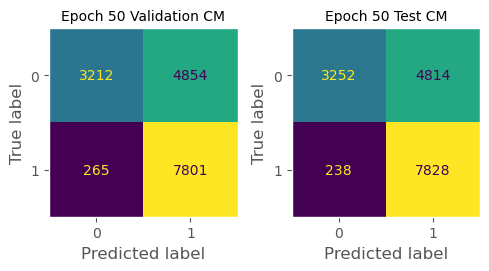

[Epoch 50/100] Loss: 0.5268 | AUC Val: 0.890 | AUC Test: 0.895
                             | F1 Val: 0.753 | F1 Test: 0.756
[Epoch 52/100] Loss: 0.5247 | AUC Val: 0.891 | AUC Test: 0.896
                             | F1 Val: 0.754 | F1 Test: 0.757
[Epoch 53/100] Loss: 0.5234 | AUC Val: 0.889 | AUC Test: 0.894
                             | F1 Val: 0.757 | F1 Test: 0.759
[Epoch 54/100] Loss: 0.5214 | AUC Val: 0.890 | AUC Test: 0.895
                             | F1 Val: 0.757 | F1 Test: 0.759
[Epoch 56/100] Loss: 0.5185 | AUC Val: 0.888 | AUC Test: 0.893
                             | F1 Val: 0.760 | F1 Test: 0.762
[Epoch 59/100] Loss: 0.5158 | AUC Val: 0.890 | AUC Test: 0.896
                             | F1 Val: 0.762 | F1 Test: 0.765
[Epoch 62/100] Loss: 0.5121 | AUC Val: 0.891 | AUC Test: 0.897
                             | F1 Val: 0.764 | F1 Test: 0.767
[Epoch 65/100] Loss: 0.5084 | AUC Val: 0.894 | AUC Test: 0.900
                             | F1 Val: 0.764 | F1 Test: 0.768


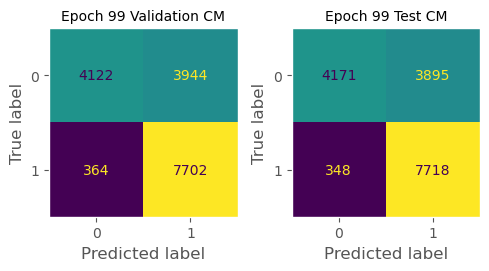

[Epoch 99/100] Loss: 0.4833 | AUC Val: 0.906 | AUC Test: 0.911
                             | F1 Val: 0.781 | F1 Test: 0.784

Best Epoch: 99 | Loss: 0.4833 | AUC Val: 0.906 | AUC Test: 0.911
                          | F1 Val: 0.781 | F1 Test: 0.784


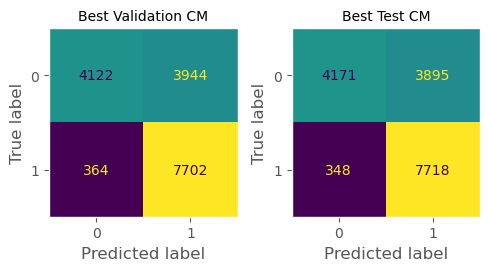

tensor([[ 0.2209,  0.0011, -0.1834,  ..., -0.0352,  0.0026,  0.1231],
        [ 0.1435, -0.0497, -0.0685,  ..., -0.1093, -0.0555,  0.0038],
        [-0.1898, -0.0285,  0.0592,  ...,  0.1724,  0.1460, -0.2407],
        ...,
        [-0.1194, -0.0399,  0.2202,  ...,  0.0934,  0.0544, -0.0563],
        [ 0.0813,  0.1628, -0.2378,  ...,  0.1781,  0.3158, -0.0312],
        [ 0.1022, -0.0210, -0.0925,  ...,  0.0100, -0.0398,  0.0301]],
       grad_fn=<AddBackward0>)

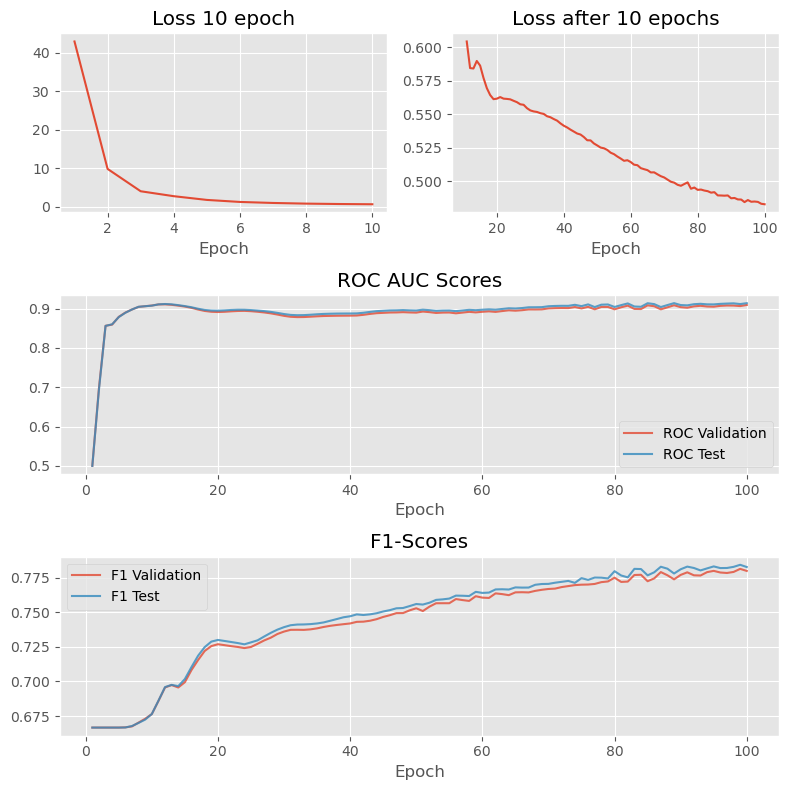

In [58]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            old_data.x.shape[1],
                            num_layers=4,
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, old_data, num_epochs=100) # AUC Val: 0.906 | AUC Test: 0.911
                                   # F1 Val: 0.781  | F1 Test: 0.784

# Citation prediction comparison

In [53]:
from scidocs.scidocs.user_activity_and_citations import make_run_from_embeddings, qrel_metrics
cit_pred_val_data = data_path + 'cite/val.qrel'
cit_pred_test_data = data_path + 'cite/test.qrel'

## Upload SPECTER 2 embeddings

In [37]:
sp2_embs = {}
with open('papers_embeddings_sp2.json', 'r') as f:
    all_sp2_embs = json.load(f)
    for id, emb in tqdm(all_sp2_embs.items(), desc='reading embeddings from file...'):
        if id in G_cite.nodes:
            sp2_embs[id] = np.array(emb, dtype=np.float32)
    del all_sp2_embs

reading embeddings from file...: 100%|██████████| 4716/4716 [00:00<00:00, 428637.56it/s]


## Train GNN

In [52]:
# gnn = LinkPredictionModel(torch_geometric.nn.GCNConv,
#                             data['train'].x.shape[1],
#                             num_layers=4,
#                             sz_hid=256,
#                             sz_out=128)
# print(gnn)
# data = train_val_test_split(G_cite, 0.0, 0.3, neg_samp_ratio=1.2)
# H = train(gnn, data, num_epochs=100, test=False) 
                   

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 256)
    (5): ReLU()
    (6): GCNConv(256, 128)
  )
)


e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [54]:
data = old_train_val_test_split(G_cite, 0.0, 0.3)
gnn = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=4,
                            sz_hid=256,
                            sz_out=128)
print(gnn)
H = old_train(gnn, data, num_epochs=100, test=False) 
                   

e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 256)
    (5): ReLU()
    (6): GCNConv(256, 128)
  )
)


## Comparison using scidocs functions


### Check the original dataset for values

In [55]:
from collections import defaultdict

with open(cit_pred_test_data) as f_in:
        qrels = [line.strip() for line in f_in]

papers = defaultdict(list)
for line in qrels:
    row = line.split(' ')
    papers[row[0]].append(row[2])

In [56]:
sum(key in G_cite.nodes() for key in papers.keys())

78

In [57]:
embeddings = load_embeddings_from_jsonl(user_activity_and_citations_embeddings_path,
                           get_graph(paper_cite_file))

reading embeddings from file...: 142009it [00:39, 3581.21it/s]


In [82]:
list(papers.keys())[0]

'78495383450e02c5fe817e408726134b3084905d'

In [92]:
len(
    set(np.concatenate(list(papers.values()))).union(
        set(embeddings.keys())
    )
)

142009

In [43]:
matching_keys = sum(key in embeddings.keys() for key in papers.keys())
print(matching_keys)

1000


In [63]:
results_path = 'cit_pred_test_sp1.qrel'
make_run_from_embeddings(
    cit_pred_test_data,
    embeddings,
    results_path,
    topk=5,
    generate_random_embeddings=False # {'map': 25.39, 'ndcg': 51.91}
    )

cite_results = qrel_metrics(cit_pred_test_data, results_path, metrics=('ndcg', 'map'))
cite_results
# {'map': 88.3, 'ndcg': 94.88}


{'map': 88.3, 'ndcg': 94.88}

### Create `.qrel` test dataset

In [64]:
def old_generate_qrel_files(data, file_prefix):
    for split in ['test']: # 'val', 
        pos_edge_index = getattr(data, f'{split}_pos_edge_index')

        # Filter nodes with at least 5 positive edges
        nodes_with_enough_edges = pos_edge_index[0].unique(return_counts=True) # pos_edge_index.unique(return_counts=True)#
        nodes_with_enough_edges = nodes_with_enough_edges[0][nodes_with_enough_edges[1] >= 5]  # topk will also be 2
        print('nodes with enough edges:', len(nodes_with_enough_edges))

        pos_edge_index = pos_edge_index[:, torch.isin(pos_edge_index[0], nodes_with_enough_edges[:1000])]
        
        neg_edge_index = generate_negative_samples(
            edge_index=pos_edge_index,
            num_nodes=len(pos_edge_index[0].unique()), # data.num_nodes,
            num_neg_samples=pos_edge_index.shape[1] * 5,
            forbidden_edge_sets=[data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index])
        #neg_edge_index = getattr(data, f'{split}_neg_edge_index')

        print(
            'pos_edges nodes len', len(pos_edge_index[0].unique()),
            '\npos_edges shape', pos_edge_index.shape,
            '\nneg_edges nodes len', len(neg_edge_index[0].unique()),
            '\nneg_edges shape', neg_edge_index.shape
            )
        print('neg_edges[0] match', neg_edge_index[:, torch.isin(neg_edge_index[0], nodes_with_enough_edges)])
        print('neg_edges[1] match', neg_edge_index[:, torch.isin(neg_edge_index[1], nodes_with_enough_edges)])

        with open(f'{file_prefix}_{split}_nodes.qrel', 'w') as file:
            for node in pos_edge_index[0].unique():
                if neg_edge_index[:, neg_edge_index[0] == node].shape[1] < 25:
                    continue
                # Positive edges for the node
                pos_edges = pos_edge_index[:, pos_edge_index[0] == node][:, :5]
                # Negative edges for the node
                neg_edges = neg_edge_index[:, neg_edge_index[0] == node][:, :25]
                #print(node, '->',neg_edges)
                
                # Write to file
                for edge in pos_edges.T:  # pos
                    file.write(f"{list(G_cite.nodes)[node.item()]} 0 {list(G_cite.nodes)[edge[1].item()]} 1\n")
                for edge in neg_edges.T:  # neg
                    file.write(f"{list(G_cite.nodes)[node.item()]} 0 {list(G_cite.nodes)[edge[1].item()]} 0\n")

old_generate_qrel_files(old_data, 'old')

nodes with enough edges: 223
pos_edges nodes len 223 
pos_edges shape torch.Size([2, 1345]) 
neg_edges nodes len 223 
neg_edges shape torch.Size([2, 6725])
neg_edges[0] match tensor([[ 48,  48,  44,  ..., 192, 139,  14],
        [ 45, 166, 168,  ..., 167,  11, 137]])
neg_edges[1] match tensor([[150, 194, 145,  ..., 104, 134, 120],
        [ 93,  99,  99,  ..., 175, 175,  11]])


In [65]:
run_path = 'cit_pred_test_sp1.qrel'
make_run_from_embeddings(
    'new_test_nodes.qrel',
    embeddings,
    run_path,
    topk=5,
    generate_random_embeddings=False
    )

cite_results = qrel_metrics(cit_pred_test_data, run_path, metrics=('ndcg', 'map'))
cite_results
# {'map': 6.67, 'ndcg': 13.26}

{'map': 5.0, 'ndcg': 14.61}

In [54]:
def generate_qrel_files(data, file_prefix):
    for split in ['test']: # 'val', 
        pos_edge_index = data[split].pos_edge_index
        neg_edge_index = data[split].neg_edge_index

        # Filter nodes with at least 5 positive edges
        nodes_with_enough_edges = pos_edge_index[0].unique(return_counts=True) # pos_edge_index.unique(return_counts=True)#
        nodes_with_enough_edges = nodes_with_enough_edges[0][nodes_with_enough_edges[1] >= 5]  # topk will also be 2
        print('nodes with enough edges:', len(nodes_with_enough_edges))

        pos_edge_index = pos_edge_index[:, torch.isin(pos_edge_index[0], nodes_with_enough_edges[:1000])]
        neg_edge_index = neg_edge_index[:, torch.isin(neg_edge_index[0], nodes_with_enough_edges[:1000])]

        print(
            'pos_edges nodes len', len(pos_edge_index[0].unique()),
            '\npos_edges shape', pos_edge_index.shape,
            '\nneg_edges nodes len', len(neg_edge_index[0].unique()),
            '\nneg_edges shape', neg_edge_index.shape
            )
        print('neg_edges[0] match', neg_edge_index[:, torch.isin(neg_edge_index[0], nodes_with_enough_edges)])
        print('neg_edges[1] match', neg_edge_index[:, torch.isin(neg_edge_index[1], nodes_with_enough_edges)])
        
        with open(f'{file_prefix}_{split}_nodes.qrel', 'w') as file:
            for node in pos_edge_index[0].unique():
                if neg_edge_index[:, neg_edge_index[0] == node].shape[1] < 5:
                    continue
                # Positive edges for the node
                pos_edges = pos_edge_index[:, pos_edge_index[0] == node][:, :5]
                # Negative edges for the node
                neg_edges = neg_edge_index[:, neg_edge_index[0] == node][:, :25]
                #print(node, '->',neg_edges)
                
                # Write to file
                for edge in pos_edges.T:  # pos
                    file.write(f"{list(G_cite.nodes)[node.item()]} 0 {list(G_cite.nodes)[edge[1].item()]} 1\n")
                for edge in neg_edges.T:  # neg
                    file.write(f"{list(G_cite.nodes)[node.item()]} 0 {list(G_cite.nodes)[edge[1].item()]} 0\n")

generate_qrel_files(data, 'new')

nodes with enough edges: 832
pos_edges nodes len 832 
pos_edges shape torch.Size([2, 5134]) 
neg_edges nodes len 736 
neg_edges shape torch.Size([2, 1811])
neg_edges[0] match tensor([[7043, 4641, 3809,  ..., 1764, 6416, 4773],
        [3344, 4640,  981,  ..., 1793, 2979, 4373]])
neg_edges[1] match tensor([[4641, 2150, 2044, 3826, 6288,  931, 2660, 5842, 4114,  857, 1480, 5000,
         1644, 2238, 1858, 2532, 4403, 4807, 5068, 1386, 1848, 2538, 2814, 6480,
         6587, 3871, 7043,   52, 1344, 3286, 1473, 4056, 4403, 1764, 2532, 7162,
         1421, 1791, 4004, 5946, 1433, 1644,  965, 1849, 2479, 5454, 1848, 6600,
          624, 2954,  817,  513,  612, 1054, 2344,  795, 5222, 6326, 3675,  822,
         4466, 3348, 3574, 6279,  498, 1839,  965, 3923, 6362, 6136, 6200, 2674,
         2199,  128, 4004, 6753,  125,  857,  517, 7303, 7226, 6132,   48, 1207,
          914, 1156,  702, 4180, 1240, 6302, 1229, 1454, 2428, 2969, 4261, 1123,
          517, 1386, 1848, 5904,  970, 3627, 4095, 22

In [57]:
gnn_embeddings = {}
for i, node in enumerate(G_cite.nodes):
    gnn_embeddings[node] = H[i].detach().numpy()

NameError: name 'H' is not defined

In [55]:
run_path = 'cit_pred_test_sp1.qrel'
make_run_from_embeddings(
    'new_test_nodes.qrel',
    embeddings,
    run_path,
    topk=5,
    generate_random_embeddings=False
    )

cite_results = qrel_metrics(cit_pred_test_data, run_path, metrics=('ndcg', 'map'))
cite_results
# {'map': 6.67, 'ndcg': 13.26}

{'map': 5.0, 'ndcg': 14.61}

In [56]:
run_path = 'cit_pred_test_gnn.qrel'
make_run_from_embeddings(
    'new_test_nodes.qrel',
    gnn_embeddings,#embeddings,
    run_path,
    topk=5,
    generate_random_embeddings=False
    )

cite_results = qrel_metrics(cit_pred_test_data, run_path, metrics=('ndcg', 'map'))
cite_results

NameError: name 'gnn_embeddings' is not defined

# Recommendation comparison part (archived)

Most code and comments are copied from https://github.com/allenai/scidocs/blob/master/scidocs/recomm_click_eval.py

## Upload propensity scores

In [35]:
recomm_path = data_path + 'recomm/'
propensity_score_path = recomm_path + 'propensity_scores.json'

with open(propensity_score_path) as f_in:
    adjClickDistribution = torch.Tensor(json.load(f_in)['scores'])

adjClickDistribution

tensor([0.5929, 0.3906, 0.3019, 0.2665, 0.2509, 0.2073, 0.1840, 0.2287, 0.2125,
        0.2423])

In [36]:
# normalize so that average propensity score is equal to one (to keep loss on similar order as without adj):
adjClickDistribution = adjClickDistribution * len(adjClickDistribution) / (
    sum(adjClickDistribution))
adjClickDistribution

tensor([2.0604, 1.3574, 1.0491, 0.9261, 0.8719, 0.7204, 0.6394, 0.7948, 0.7385,
        0.8420])

I've found what are those propencity scores in the SPECTER paper:
___
As is typical in clickthrough data on ranked lists, the clicks are biased toward the top of original ranking presented to the user. To counteract this effect, we computed `propensity scores` using a swap experiment (Agarwal et al., 2019). The `propensity scores` give, **for each position in the ranked list, the relative frequency that the position is over-represented in the data due to exposure bias.** We can then compute de-biased evaluation metrics by dividing the score for each test example by the propensity score for the clicked position
___

## Upload test or validation data (their metrics were achieved on **test** dataset)

In [37]:
test_data_path = recomm_path + 'test.csv'
val_data_path = recomm_path + 'val.csv'

df_test = pd.read_csv(test_data_path)

df_test.head()

,pid,clicked_pid,similar_papers_avail_at_time
0,70fc27072f024415a812c2d819bfc6b50eefe326,65d3b7df2087134220369ac5c9f4f440ca538d08,"5b2646605d804285176574c5f27f2974e83288e2,fee0c..."
1,f781499f9a2a81dfe50068d32bfe9f36449f1dc6,06c0db75dce988e17e27fb4f2269815c6075e8d8,"562e2a1300e96cf882e17d7dee711d2dedac0580,06c0d..."
2,f8e8f26442a022b2a89b498d7e80701a86ff6691,2268a522cc5a749da38b4e9aaaa6f4239e82ca31,"2268a522cc5a749da38b4e9aaaa6f4239e82ca31,0033a..."
3,92113b42ff8b9a09e45e7292b201e225bc89c379,171444e1456e3136ff4bec661eea5e75464d39b8,"f3fdfc21ff5fb93625a65063f6f32b11d42a3218,17144..."
4,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,90096a59f94b552351ad386db7bee8f1932badc8,"08663b3b57c85d8270acf1931041050d26599c7e,90096..."


`similar_papers_avail_at_time` always have 10 papers inside divided by commas as one string

In [38]:
display(df_test['similar_papers_avail_at_time'])

df_test['similar_papers_avail_at_time'].str.split(',').apply(len).describe()

0      5b2646605d804285176574c5f27f2974e83288e2,fee0c...
1      562e2a1300e96cf882e17d7dee711d2dedac0580,06c0d...
2      2268a522cc5a749da38b4e9aaaa6f4239e82ca31,0033a...
3      f3fdfc21ff5fb93625a65063f6f32b11d42a3218,17144...
4      08663b3b57c85d8270acf1931041050d26599c7e,90096...
                             ...                        
995    2dbe0138ca07dbd9daa3d8d118c1ee2c49620b90,1c2a6...
996    577c4b3ad6ff6324878623c35f47ea4457d415d9,f3372...
997    7e5e5063cba7f4e41c2366eab80c1b2c6aaefa77,a6949...
998    0f31a74ec5cecab2314358bec4457738354bbc76,66f2c...
999    34b4a6ba45efe90c77b245890227cb35c598849e,784e3...
Name: similar_papers_avail_at_time, Length: 1000, dtype: object

count    1000.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: similar_papers_avail_at_time, dtype: float64

### Check the data consistency with our embeddings dataset

Unique values in `val`/`test` dataset

In [39]:
np.unique(
    np.concatenate([
        df_test['pid'].unique(),
        df_test['clicked_pid'].unique(),
        np.concatenate(df_test['similar_papers_avail_at_time'].str.split(','))])
    ).shape


(8758,)

In [40]:
len(set(G_cite.nodes))

4716

Intersection of `ids` in both datasets

In [41]:
len(set(np.concatenate([
        df_test['pid'].unique(),
        df_test['clicked_pid'].unique(),
        np.concatenate(df_test['similar_papers_avail_at_time'].str.split(','))
    ])).intersection(set(G_cite.nodes)))

1104

Before it was 90, so the situation improved a little

### Filter the dataset to have only available papers 

In [42]:
# Create mask to filter only available papers in 'pid' and 'clicked_pid' cols
mask = (df_test['pid'].isin(G_cite.nodes)) & (df_test['clicked_pid'].isin(G_cite.nodes))
df_test = df_test[mask]

# Split the 'sim_papers' col and leave values that are available in the Graph
df_test['similar_papers_avail_at_time'] = df_test['similar_papers_avail_at_time'].str.split(',')
df_test['similar_papers_avail_at_time'] = df_test['similar_papers_avail_at_time'].apply(
                                        lambda ls: [paper for paper in ls if paper in G_cite.nodes]
                                    )

# Get rid of rows with less then 2 values (comparison won't make sence)
df_test = df_test[df_test['similar_papers_avail_at_time'].apply(len) > 1]
df_test['similar_papers_avail_at_time'] = df_test['similar_papers_avail_at_time'].apply(lambda lst: ','.join(lst))
display(df_test)

# Upload filtered dataset
test_filtered_data_path = recomm_path + 'test_filtered.csv'
df_test.to_csv(test_filtered_data_path, index=False)

,pid,clicked_pid,similar_papers_avail_at_time
4,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,90096a59f94b552351ad386db7bee8f1932badc8,"90096a59f94b552351ad386db7bee8f1932badc8,821fd..."
6,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,821fd5bed14d6d06c25fbf44123fd7be382f7b4e,"90096a59f94b552351ad386db7bee8f1932badc8,821fd..."
14,6dae703128d9caff2623eb8dfe2526dc6ad7aff5,4a63437aaee3267a5b427588adecb1c73a95b423,"4a63437aaee3267a5b427588adecb1c73a95b423,0ce54..."
17,cb40a5e6d4fc0290452345791bb91040aed76961,c6a9ca56c93323c0199dd22631d1cf731bdd7ec1,"8fd1d13e18c5ef8b57296adab6543cb810c36d81,5772b..."
18,3d9d1c26a8dc82ca54154d6f2304507ce65bcb35,fc7d91dbb549a5c834d663944670bf4f08bc9b00,"7874c01633ca800b6e38b188dd0b1cbf6f3f9ece,0dc6f..."
...,...,...,...
935,1e56ed3d2c855f848ffd91baa90f661772a279e1,3d74d241af53d85cbc74f73a785fddd675f0e644,"3d74d241af53d85cbc74f73a785fddd675f0e644,9e6f3..."
937,cf755dd097b7286e8e53ba637c495229f2587e84,1b49a3b9a44c5213a03129faba81cccc75a4d5ff,"1b49a3b9a44c5213a03129faba81cccc75a4d5ff,b946c..."
948,9a6a8cbb10b719cdb565ca9be01c7bf4df049bf0,560d3334047c0455951a4a672941103bf49c1f40,"3e5655307333589f52f2aab8678f3e1c9184a88f,b77b4..."
985,a217e85ca33c46ebb06812fdd30f133a83cd0890,3b3291e1f908f583a478e15fb40bffb6dd26cf14,"3b3291e1f908f583a478e15fb40bffb6dd26cf14,ad66b..."


### Open the `csv` as it was in original code

In [43]:
with open(test_filtered_data_path, 'r') as f_in:
    clicks = f_in.read().splitlines()

print(f"Clicks variable contain {len(clicks[1:])} examples with columns:")

for i, cl in enumerate(clicks[0].split(',')):
    print(f'{i+1}.{cl}')

clicks = clicks[1:]

Clicks variable contain 71 examples with columns:
1.pid
2.clicked_pid
3.similar_papers_avail_at_time


## Comparison for-loop (work in progress)

In [44]:
#sp2_embs = pd.read_json('papers_embeddings_sp2.json')
sp2_embs = {}
with open('papers_embeddings_sp2.json', 'r') as f:
    all_sp2_embs = json.load(f)
    for id, emb in tqdm(all_sp2_embs.items(), desc='reading embeddings from file...'):
        if id in G_cite.nodes:
            sp2_embs[id] = np.array(emb, dtype=np.float32)
    del all_sp2_embs


reading embeddings from file...: 100%|██████████| 4716/4716 [00:00<00:00, 16254.41it/s]


In [54]:
gnn = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=3,
                            sz_hid=256,
                            sz_out=128)
print(gnn)
data = train_val_test_split(G_cite, 0,0)
H = train(gnn, data, num_epochs=100, test=False)  # new embs AUC Val: 0.977 | AUC Test: 0.976 | F1 Val : 0.823 | F1 Test: 0.825
                                

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 128)
  )
)


Function for finding euclidean distance on SPECTER 2 embeddings

In [64]:
from scipy.spatial.distance import euclidean

def find_L2_distance_SPECTER2(embs, query_paper_id, comp_paper_id):
    """
    Computes the negative L2 (Euclidean) distance between the embeddings of two papers,
    effectively turning the distance metric into a similarity metric where larger values indicate closer or more similar papers.

    Parameters:
      embs (dict): the embeddings dictionary containing 'id': 'embedding_vector' pairs
      query_paper_id (str): The identifier for the query paper. This ID should correspond to a key in the `sp2_embs` dictionary.
      comp_paper_id (str): The identifier for the comparison paper. This ID should also correspond to a key in the `sp2_embs` dictionary.

    Returns:
      float: The negative L2 distance between the embeddings of the query paper and the comparison paper.
    
    """

    # Retrieve the embeddings for the query and comparison papers from the pre-loaded embeddings dictionary
    query_emb = embs[query_paper_id]
    comp_emb = embs[comp_paper_id]

    # Compute the Euclidean (L2) distance between the two embeddings
    dist = euclidean(query_emb, comp_emb)

    # Return the negative distance to convert the distance metric into a similarity metric
    # A larger (less negative) value indicates a smaller distance or higher similarity
    return -dist


Function for receiving dot-product between two paper nodes in GNN (in progress)

In [61]:
def get_dot_prod_GNN(H, G, query_paper, comp_paper):
    """
    Computes the dot product similarity between two nodes (papers) in a graph using a trained GNN.

    Parameters:
      H (Tensor): The node embeddings matrix produced by the GNN, where each row corresponds to a node's embedding.
      query_paper (str): The id of the query paper node in the graph.
      comp_paper (str): The id of the comparison paper node in the graph.

    Returns:
      dot_prod_res (Tensor): The dot product result representing the similarity between the query paper and the comparison paper.
    """

    # Convert the graph nodes into a list to work with indices
    nodes_list = list(G.nodes())  # Assuming G_cite is a pre-defined graph variable

    # Find the indices of the query and comparison papers in the nodes list
    query_and_comp_edge_ind = ([nodes_list.index(query_paper)], [nodes_list.index(comp_paper)])

    # Use the GNN's decode method to compute the dot product similarity between the embeddings of the two papers
    dot_prod_res = gnn.decode(H, query_and_comp_edge_ind)

    return dot_prod_res

RankMetricsCalculator class to calculate all metrics related stuff and improve the structure

In [48]:
class RankMetricsCalculator:
    """
    A class to calculate various ranking metrics including accuracy, normalized discounted cumulative gain (NDCG),
    mean reciprocal rank (MRR), and precision at rank 1 (Rprec/P@1), along with their adjusted versions.
    """

    def __init__(self):
        # Counts of items ranked in correct and incorrect order
        self.correct_order = 0
        self.incorrect_order = 0

        # Accumulators for metrics
        self.mrr = 0
        self.ndcg_numerator = 0
        self.rprec = 0

        # Adjusted metrics accumulators
        self.adj_demonimator = 0
        self.adj_ndcg_numerator = 0
        self.adj_correct_order = 0
        self.adj_incorrect_order = 0
        self.adj_mrr = 0
        self.adj_rprec = 0

    def calculate_metrics(self, neg_scores, pos_score, adj):
        """
        Calculates and updates ranking metrics based on the scores of negative (incorrect) and positive (correct) instances,
        and an adjustment factor for adjusted metrics.

        Parameters:
          neg_scores (list of float): Scores of negative instances.
          pos_score (float): Score of the positive instance.
          adj (float): Adjustment factor for calculating adjusted metrics.
        """
        # Count how many negative scores are ranked above and below the positive score
        ranked_above = sum(1 for x in neg_scores if x > pos_score)
        ranked_below = sum(1 for x in neg_scores if x < pos_score)

        # Handle ties by assigning half a point to both above and below for each tie
        ranked_above += sum(0.5 for x in neg_scores if x == pos_score)
        ranked_below += sum(0.5 for x in neg_scores if x == pos_score)

        # Update counts of correct and incorrect orders
        self.correct_order += ranked_below
        self.incorrect_order += ranked_above
        
        # Calculate and update metrics
        ndcg = 1 / np.log2(2 + ranked_above)  # NDCG calculation for the current instance
        self.mrr += 1 / (1 + ranked_above)  # MRR update
        self.ndcg_numerator += ndcg  # NDCG numerator update
        self.rprec += 1 if ranked_above == 0 else 0  # Rprec/P@1 update
        
        # Calculate and update adjusted metrics using the adjustment factor
        self.adj_demonimator += adj
        self.adj_ndcg_numerator += adj * ndcg
        self.adj_correct_order += adj * ranked_below
        self.adj_incorrect_order += adj * ranked_above
        self.adj_mrr += adj * (1 / (1 + ranked_above))
        self.adj_rprec += adj * (1 if ranked_above == 0 else 0)

    def get_results(self, clicks):
        """
        Calculates and returns the final metrics based on the accumulated values and the number of clicks (instances).

        Parameters:
          clicks (list): The list of clicks or instances considered for the metrics calculation.

        Returns:
          metrics (dict): A dictionary containing the calculated metrics.
        """
        metrics = {
            "accuracy": self.correct_order / (self.correct_order + self.incorrect_order),
            "ndcg": self.ndcg_numerator / len(clicks),
            "mrr": self.mrr / len(clicks),
            "Rprec/P@1": self.rprec / len(clicks),
            "Adj-accuracy": self.adj_correct_order / (self.adj_incorrect_order + self.adj_correct_order),
            "Adj-ndcg": self.adj_ndcg_numerator / self.adj_demonimator,
            "Adj-mrr": self.adj_mrr / self.adj_demonimator,
            "Adj-Rprec/P@1": self.adj_rprec / self.adj_demonimator
        }
        return metrics


In [66]:
metrics_calculator_specter = RankMetricsCalculator()
metrics_calculator_gnn = RankMetricsCalculator()

for line in tqdm(clicks):
        # Prepare ids from file
        [query_id, clicked_id, other_id_str] = list(csv.reader([line], delimiter=',', quotechar='"'))[0]
        other_ids = other_id_str.strip().split(",")
        position = 1
        paper_score_specter = [] #used for output
        paper_score_gnn = [] #used for output

        # Find positive query-recom scores
        clicked_position = other_ids.index(clicked_id) + 1
        pos_score_specter = find_L2_distance_SPECTER2(sp2_embs, query_id, clicked_id)
        pos_score_gnn = get_dot_prod_GNN(H, G_cite, query_id, clicked_id)
        paper_score_specter.append([clicked_id, pos_score_specter])
        paper_score_gnn.append([clicked_id, pos_score_gnn])

        # Find negative query-recom scores
        neg_scores_specter = []
        neg_scores_gnn = []
        adj = 1 / adjClickDistribution[clicked_position-1]
        for other_id in other_ids:
            if not other_id == clicked_id:
                neg_score_specter = find_L2_distance_SPECTER2(sp2_embs, query_id, other_id)
                neg_score_gnn = get_dot_prod_GNN(H, G_cite, query_id, other_id)
                neg_scores_specter.append(neg_score_specter)
                neg_scores_gnn.append(neg_score_gnn)
                paper_score_specter.append([other_id, neg_score_specter])
                paper_score_gnn.append([other_id, neg_score_gnn])
            position = position + 1
        
        metrics_calculator_specter.calculate_metrics(neg_scores_specter, pos_score_specter, adj)
        metrics_calculator_gnn.calculate_metrics(neg_score_gnn, pos_score_gnn, adj)

metrics_specter = metrics_calculator_specter.get_results(clicks)
metrics_gnn = metrics_calculator_gnn.get_results(clicks)

display('SPECTER 2:', metrics_specter,
      'GNN', metrics_gnn)

100%|██████████| 71/71 [00:00<00:00, 611.93it/s]


'SPECTER 2:'

{'accuracy': 0.6658291457286433,
 'ndcg': 0.6408412230074018,
 'mrr': 0.5243125419181757,
 'Rprec/P@1': 0.2676056338028169,
 'Adj-accuracy': tensor(0.6588),
 'Adj-ndcg': tensor(0.6113),
 'Adj-mrr': tensor(0.4861),
 'Adj-Rprec/P@1': tensor(0.2285)}

'GNN'

{'accuracy': 0.5985915492957746,
 'ndcg': 0.8510211816530542,
 'mrr': 0.7981220657276995,
 'Rprec/P@1': 0.5915492957746479,
 'Adj-accuracy': tensor(0.6052),
 'Adj-ndcg': tensor(0.8538),
 'Adj-mrr': tensor(0.8019),
 'Adj-Rprec/P@1': tensor(0.6010)}

In [59]:
# SPECTER-2
# {'accuracy': 0.6658291457286433,
#  'ndcg': 0.6408412230074018,
#  'mrr': 0.5243125419181757,
#  'Rprec/P@1': 0.2676056338028169,
#  'Adj-accuracy': tensor(0.6588),
#  'Adj-ndcg': tensor(0.6113),
#  'Adj-mrr': tensor(0.4861),
#  'Adj-Rprec/P@1': tensor(0.2285)}

# SPECTER
# {'accuracy': 0.6256281407035176,
#  'ndcg': 0.6118552846993199,
#  'mrr': 0.4871450927788954,
#  'Rprec/P@1': 0.23943661971830985,
#  'Adj-accuracy': tensor(0.6344),
#  'Adj-ndcg': tensor(0.5911),
#  'Adj-mrr': tensor(0.4601),
#  'Adj-Rprec/P@1': tensor(0.2075)}

# GNN (NEW result)
# {'accuracy': 0.5985915492957746,
#  'ndcg': 0.8510211816530542,
#  'mrr': 0.7981220657276995,
#  'Rprec/P@1': 0.5915492957746479,
#  'Adj-accuracy': tensor(0.6052),
#  'Adj-ndcg': tensor(0.8538),
#  'Adj-mrr': tensor(0.8019),
#  'Adj-Rprec/P@1': tensor(0.6010)}

# GNN (OLD result)
# {'accuracy': 0.5841708542713567,
#  'ndcg': 0.6051892136642196,
#  'mrr': 0.4803330081499094,
#  'Rprec/P@1': 0.23943661971830985,
#  'Adj-accuracy': tensor(0.5528),
#  'Adj-ndcg': tensor(0.5593),
#  'Adj-mrr': tensor(0.4214),
#  'Adj-Rprec/P@1': tensor(0.1808)}